In [66]:
import numpy as np  
from scipy.integrate import odeint  
import matplotlib.pyplot as plt
import cvxpy as cp
import math
import time
import random

### DO Dynamics

In [67]:
class FishTank:
    def __init__(self, initial_DO, temperature, fish_count, plant_count, organic_matter, pump_rate):
        self.DO = initial_DO  # 초기 DO 값
        self.temperature = temperature  # 수온
        self.fish_count = fish_count  # 물고기 수
        self.plant_count = plant_count  # 식물 수
        self.organic_matter = organic_matter  # 유기물 양
        self.pump_rate = pump_rate  # 펌프가 켜졌을 때 산소 증가율

    # 시간당 DO 변화율을 계산하는 함수
    def oxygen_dynamics(self, DO, t, pump_on):
        # 물고기 산소 소비(시간당 산소 소비율)
        fish_oxygen_consumption = self.fish_count * self.fish_oxygen_rate()
        # 식물 산소 소비
        plant_oxygen_consumption = self.plant_count * self.plant_oxygen_rate()
        # 유기물 분해에 의한 산소 소비
        organic_oxygen_consumption = self.organic_matter_decomposition_rate()
        # 총 산소 소비
        total_oxygen_consumption = fish_oxygen_consumption + plant_oxygen_consumption + organic_oxygen_consumption
        
        # 펌프 켜져 있을 때 산소 공급량
        oxygen_addition = self.pump_rate if pump_on else 0
        
        dDOdt_10 = (oxygen_addition - total_oxygen_consumption)
                
        # 온도에 따른 산소 소비율 변화
        temperature_factor = (self.temperature - 10)/10
        if isinstance(temperature_factor, complex):
            temperature_factor = temperature_factor.real
    
        dDOdt_float = dDOdt_10 ** temperature_factor
        
        # 복소수인지 확인 후 실수로 변환
        if isinstance(dDOdt_float, complex):
            dDOdt_float = dDOdt_float.real
        
        dDOdt = round(dDOdt_float, 2)
        return dDOdt


    def fish_oxygen_rate(self):
        return 0.1

    def plant_oxygen_rate(self):
        return 0.05


    def organic_matter_decomposition_rate(self):
        return self.organic_matter * 0.01

    # 온도에 따른 산소 소비율 변화 계산
    # def temperature_effect(self):
    #     return 1 + (self.temperature - 20) * 0.05 
    # 20도가 기준, 온도 1도 증가 시 5% 증가

"""
    # 시뮬레이션 함수
    def simulate(self, total_minutes, pump_schedule):
        time_intervals = total_minutes // 5  # 5분 단위로 나눈 시간 간격 수
        t = np.linspace(0, total_minutes / 60, time_intervals + 1)  # 시뮬레이션 시간 벡터 (5분 단위)
        DO = self.DO  # 초기 DO 값
        DO_history = np.zeros(len(t), dtype=float)

        for i in range(1, len(t)):  # 시간 벡터를 순회하며 DO 업데이트
            minute_index = (i - 1) // 3  # 15분 단위로 펌프 스케줄링
            if minute_index < len(pump_schedule):
                pump_on = pump_schedule[minute_index]
            else:
                pump_on = pump_schedule[-1]
            
            delta_t = t[i] - t[i - 1]
            DO = odeint(self.oxygen_dynamics, DO, [t[i - 1], t[i]], args=(pump_on, delta_t))[-1]
            DO_history[i] = DO
            
        return t, DO_history
""" 

'\n    # 시뮬레이션 함수\n    def simulate(self, total_minutes, pump_schedule):\n        time_intervals = total_minutes // 5  # 5분 단위로 나눈 시간 간격 수\n        t = np.linspace(0, total_minutes / 60, time_intervals + 1)  # 시뮬레이션 시간 벡터 (5분 단위)\n        DO = self.DO  # 초기 DO 값\n        DO_history = np.zeros(len(t), dtype=float)\n\n        for i in range(1, len(t)):  # 시간 벡터를 순회하며 DO 업데이트\n            minute_index = (i - 1) // 3  # 15분 단위로 펌프 스케줄링\n            if minute_index < len(pump_schedule):\n                pump_on = pump_schedule[minute_index]\n            else:\n                pump_on = pump_schedule[-1]\n            \n            delta_t = t[i] - t[i - 1]\n            DO = odeint(self.oxygen_dynamics, DO, [t[i - 1], t[i]], args=(pump_on, delta_t))[-1]\n            DO_history[i] = DO\n            \n        return t, DO_history\n'

### PID Controller

In [68]:
class PIDController:
    def __init__(self, Kp, Ki, Kd, setpoint):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.setpoint = setpoint
        self.previous_error = 0
        self.integral = 0

    def update(self, measurement, dt):
        error = self.setpoint - measurement
        self.integral += error * self.Ki * dt
        derivative = (error - self.previous_error) / dt * self.Kd
        
        output = self.Kp * error + self.integral + derivative
        
        self.previous_error = error
        
        return output


In [69]:
# 초기 설정 값
initial_DO = 4.1
temperature = 18.2  #두개만 따로 나중에 불러오면 됨
fish_count = 90
plant_count = 5 
organic_matter = 1
pump_rate = 15

tank = FishTank(initial_DO, temperature, fish_count, plant_count, organic_matter, pump_rate)

In [70]:
pid = PIDController(Kp=0.3, Ki=0.05, Kd=0.1, setpoint=4.5)

# 시뮬레이션 15분
current_time = 0
time_step = 1/12

DO_values = []  # 시간에 따른 DO 값을 저장할 리스트
pump_states = []  # 시간에 따른 펌프 작동 여부를 저장할 리스트

i=1
while current_time < time_step * 24:  # n 시간 동안 시뮬레이션
    DO = tank.DO
    
    # 노이즈 추가 (예: -0.1 ~ 0.1 범위의 노이즈)
    noise = random.uniform(-0.5, 0.5)
    
    DO_values.append(DO)
    control_signal = pid.update(DO, time_step)
    pump_on = 1 if control_signal > 0 else 0
    pump_states.append(pump_on)
    dDOdt = tank.oxygen_dynamics(DO, current_time, pump_on)
    
    # DO 업데이트
    tank.DO += dDOdt * time_step + noise
    current_time += time_step
    
    # print(f"{i:.0f}step: {current_time * 60:.0f} min, DO: {tank.DO:.3f}, pump: {'ON' if pump_on else 'OFF'}, {control_signal:.3f}")
    time.sleep(0.2)  # 시뮬레이션 속도 조절을 위한 딜레이
    
    
    i+=1
    
print(pump_states.count(1))    

14


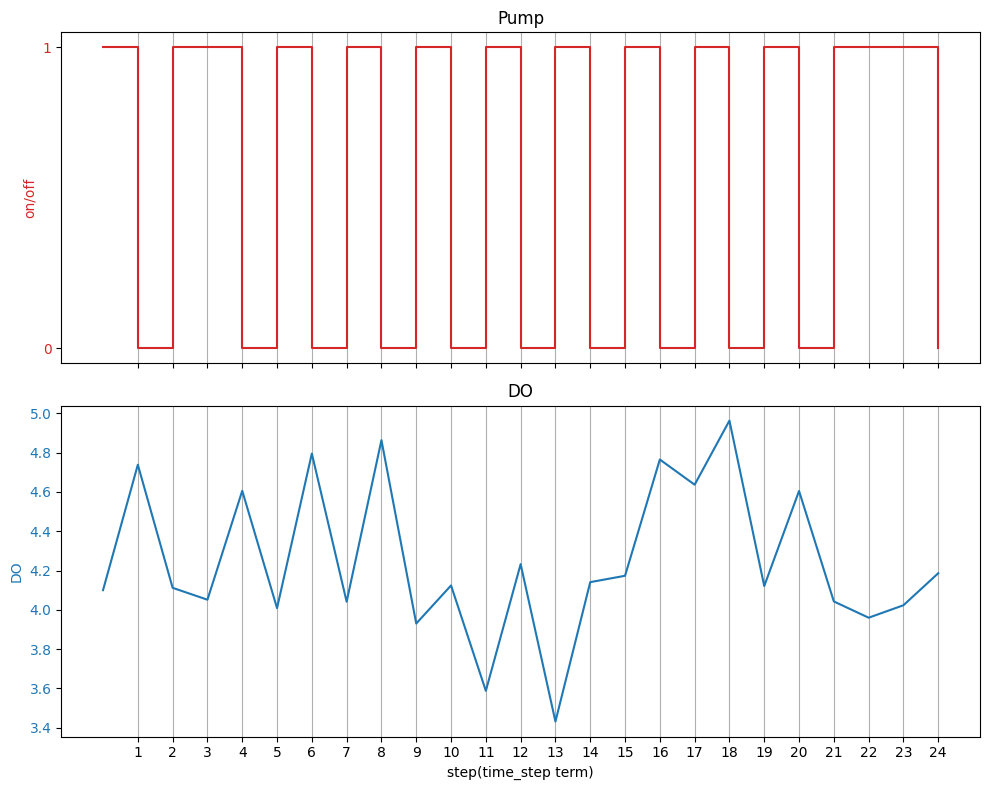

In [71]:
"""
# 그래프 그리기
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Time (5m)')
ax1.set_ylabel('DO', color=color)
ax1.plot(range(len(DO_values)), DO_values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('pump', color=color)
ax2.plot(range(len(pump_states)), pump_states, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.grid(True)
plt.show()
"""

# 결과를 보간하여 펌프 상태를 일정 시간 유지
DO_times = np.arange(0, len(DO_values) * time_step, time_step)
pump_times = np.arange(0, len(pump_states) * time_step, time_step)

# print(len(DO_times))
# print(len(DO_values))

DO_values_interp = np.interp(np.arange(0, 24, time_step), DO_times, DO_values)
pump_states_interp = np.interp(np.arange(0, 24, time_step), pump_times, pump_states)

# 시각화
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

# 펌프 작동 여부
color = 'tab:red'
ax1.set_ylabel('on/off', color=color)
ax1.step(range(len(pump_states)), pump_states, color=color, where='post')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, axis='x')
ax1.set_yticks([0, 1])
ax1.set_title('Pump')

# DO 변화
color = 'tab:blue'
ax2.set_xlabel('step(time_step term)')
ax2.set_ylabel('DO', color=color)
ax2.plot(range(len(DO_values)), DO_values, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(True, axis='x')
ax2.set_title('DO')

plt.xticks(np.arange(1, len(DO_values)))
plt.tight_layout()
plt.show()

* 센서-컨트롤러-액츄에이터
* 모델을 시스템에 적용시키면 좋은데 힘드니까 모델=시스템 가정
* control parameter를 통해 문 열마나 열지 결정하게 되면 기존 정보가 바뀌어야지
* 지금 인공지능: do1->(lstm)->do2 이 do2에서 do1로 다시 입력값 반복
* 특정 임계점을 유지하도록 펌프를 작동시키는 게 중요하겠지

* 어떤 모델인지
* lstm에는 펌프관련 내용이 없어서 그걸 연결할 수 있는 모델을 활용해야

* pid의출력은 펌프 입력이고 펌프 출력은 
---
* time_step 별로 결과 비슷한 이유
1. 파라미터 재설정
2. 산소 변화율, 산소 공급량이 일정하기 때문에 펌프가 작동되는 시간도 비슷한거아닐가?
-> 노이즈 고려 ㄱㄱ


* 그럼 지금 할거
1. do 임계선.. 특정값 or 범위?
2. 하루종일 켜져있는데 왜 do는 거의 그대로임? (아 물고기 호흡량이 너무 많아서 그런가)
3. ai 연결

* 산소 일정 이유
산소 공급과 소모의 균형 / 효율적인 물 순환 시스템

---
인공지능으로 예측된거랑 제어를통해 예측된거랑 비교해서 
15분 이후 예측 활용..

수온에따라서 올라가는 호흡량 기준

### MPC

In [72]:
class MPCController:
    def __init__(self, tank, horizon, target_DO, DO_min, DO_max):
        self.tank = tank
        self.horizon = horizon  # 예측 시간대
        self.target_DO = target_DO 
        self.DO_min = DO_min 
        self.DO_max = DO_max

    def optimize(self, current_DO):
        u = cp.Variable(self.horizon, boolean=True)  # 펌프 온오프 결정 변수
        DO = cp.Variable(self.horizon + 1)  # 예측 do 농도
        
        cost = 0  # 초기 비용 함수
        constraints = [DO[0] == current_DO]  # 초기 do 농도 제약

        for t in range(self.horizon):
            dDOdt = self.tank.oxygen_dynamics(DO[t], t, u[t])
            constraints += [DO[t+1] == DO[t] + dDOdt]
            constraints += [DO[t+1] >= self.DO_min]
            constraints += [DO[t+1] <= self.DO_max]
            cost += cp.square(DO[t+1] - self.target_DO)  # 비용 함수 업데이트

        
        problem = cp.Problem(cp.Minimize(cost), constraints) 
        problem.solve()
        
        return u.value  # 최적의 펌프 제어 신호 반환
    

In [73]:
# MPC 설정
horizon = 5
target_DO = pid.setpoint  # 목표 용존산소 농도
DO_min = 3.5  # 최소 용존산소 농도
DO_max = 7.0  # 최대 용존산소 농도



In [74]:
mpc = MPCController(tank, horizon, target_DO, DO_min, DO_max)  # MPCController 객체 생성

current_DO = initial_DO  # 현재 용존산소 농도
control_signal_mpc = mpc.optimize(current_DO)  # 최적의 펌프 제어 신호 계산
print(f"Optimal pump control for the next {horizon} hours: {control_signal_mpc}")  # 최적의 펌프 제어 신호 출력

"""
plt.title('Pump Control')
plt.xlabel('Time')
plt.ylabel('Control Signal')
plt.legend()
plt.grid(True)
plt.xticks(range(1, 176))
plt.yticks([0, 1])
plt.show()
"""

"""
for horizon in range(1, 25):
    # 현재 DO에서 최적의 펌프 제어 신호 계산
    current_DO = 8.0  # 현재 용존산소 농도
    control_signal = mpc.optimize(current_DO)  # 최적의 펌프 제어 신호 계산
    print(f"Optimal pump control for the next {horizon} hours: {control_signal}")  # 최적의 펌프 제어 신호 출력
"""

Optimal pump control for the next 5 hours: None


'\nfor horizon in range(1, 25):\n    # 현재 DO에서 최적의 펌프 제어 신호 계산\n    current_DO = 8.0  # 현재 용존산소 농도\n    control_signal = mpc.optimize(current_DO)  # 최적의 펌프 제어 신호 계산\n    print(f"Optimal pump control for the next {horizon} hours: {control_signal}")  # 최적의 펌프 제어 신호 출력\n'

### simulate함수 시험용

In [75]:
"""
tank = FishTank(initial_DO, temperature, fish_count, plant_count, organic_matter, pump_rate)

# 펌프 일정 (하루 단위로 켜고 끄기: 1 켜짐 0 꺼짐)
pump_schedule = [0] * 1 + [1] * 4 + [0] * 2 

# 시뮬레이션 실행
t, DO_history = tank.simulate(7, pump_schedule)

# 시각화
plt.plot(t, DO_history)
plt.xlabel('Time')
plt.ylabel('DO (mg/L)')
plt.title('DO')
plt.show()
"""

"\ntank = FishTank(initial_DO, temperature, fish_count, plant_count, organic_matter, pump_rate)\n\n# 펌프 일정 (하루 단위로 켜고 끄기: 1 켜짐 0 꺼짐)\npump_schedule = [0] * 1 + [1] * 4 + [0] * 2 \n\n# 시뮬레이션 실행\nt, DO_history = tank.simulate(7, pump_schedule)\n\n# 시각화\nplt.plot(t, DO_history)\nplt.xlabel('Time')\nplt.ylabel('DO (mg/L)')\nplt.title('DO')\nplt.show()\n"